# MMA867 Team Assignment 1

## Objective

Implement a predictive model levereging Lasso & Ridge regression techniques to predict housing saleprices.

## Data Information

* **train.csv** - Training dataset to build our model
*  **test.csv** - Test set that will be used for generating predictions

Each record in the train and test datasets contain 79 explanitory attribuites used to describe homes 

### Import necessary libraries

In [170]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

sns.set()

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to split the data into train and test
from sklearn.model_selection import train_test_split

# to build linear regression_model
from sklearn.linear_model import LinearRegression,Lasso,LassoCV,Ridge,RidgeCV
from statsmodels.formula.api import ols
import statsmodels.api as sme

# imputing missing data
import statsmodels.imputation.mice as mice
import statsmodels.regression.linear_model as sm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

# to check model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

#Perform the Breuch-Pagan Test
from statsmodels.stats.diagnostic import het_breuschpagan


In [171]:
#Loading training and Test data

df = pd.read_csv('train.csv')

df2 = pd.read_csv('test.csv')

# Saving ID's 
train_id = df['Id']
test_id = df2['Id']

print(f'There are {df.shape[0]} rows and {df.shape[1]} columns in Training data')
print(f'There are {df2.shape[0]} rows and {df2.shape[1]} columns in Testing data')

There are 1460 rows and 81 columns in Training data
There are 1459 rows and 80 columns in Testing data


### Data Preprocessing

In [172]:
#creating a copy of training and testing data
training = df.copy()
testing = df2.copy()


# Creating dependent house saleprice variable 
Y = training[['SalePrice']]
Y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   SalePrice  1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


In [173]:
# Concatenating test and training data for data cleaning and imputation purposes
training['Training'] = 1
testing['Training'] = 0

traincombined = pd.concat([training.drop(['SalePrice','Id'],axis=1),testing.drop('Id',axis=1)])

traincombined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuilt    

* Dependent variable is `SalePrice` which is of *int* type
* Remaining fields are of *float* , *int* , and *object* types
* Significant null values present in `PoolQC`, `MiscFeature`, `Fence`, and `Alley` Fields

`ID` field is dropped as it's not required for model training  

**Missing Values Check**

In [174]:
# looking at which columns have the most missing values
traincombined.isnull().sum().sort_values(ascending=False)

PoolQC           2909
MiscFeature      2814
Alley            2721
Fence            2348
MasVnrType       1766
FireplaceQu      1420
LotFrontage       486
GarageCond        159
GarageQual        159
GarageYrBlt       159
GarageFinish      159
GarageType        157
BsmtCond           82
BsmtExposure       82
BsmtQual           81
BsmtFinType2       80
BsmtFinType1       79
MasVnrArea         23
MSZoning            4
BsmtHalfBath        2
Functional          2
BsmtFullBath        2
Utilities           2
BsmtUnfSF           1
KitchenQual         1
BsmtFinSF1          1
SaleType            1
GarageCars          1
GarageArea          1
TotalBsmtSF         1
Exterior2nd         1
Exterior1st         1
Electrical          1
BsmtFinSF2          1
TotRmsAbvGrd        0
Fireplaces          0
MSSubClass          0
BedroomAbvGr        0
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
MiscVal   

In [175]:
#Inspecting value distributions for each categorical field

num_to_display = 10  # showing top 10 can be adjusted later

for colname in df.dtypes[df.dtypes == 'object'].index:
    
    val_counts = traincombined[colname].value_counts(dropna=False)  # I want to see NA counts
    
    val_counts_percent = ((val_counts/len(traincombined))*100).round(2)
    
    print((val_counts_percent[:num_to_display]).astype(str) + '%')
    
    if len(val_counts) > num_to_display:
        
        print(f"Only displaying first {num_to_display} of {len(val_counts)} values.")
        
    print('\n\n')

MSZoning
RL          77.6%
RM         15.76%
FV          4.76%
RH          0.89%
C (all)     0.86%
NaN         0.14%
Name: count, dtype: object



Street
Pave    99.59%
Grvl     0.41%
Name: count, dtype: object



Alley
NaN     93.22%
Grvl     4.11%
Pave     2.67%
Name: count, dtype: object



LotShape
Reg    63.69%
IR1    33.16%
IR2      2.6%
IR3     0.55%
Name: count, dtype: object



LandContour
Lvl    89.83%
HLS     4.11%
Bnk     4.01%
Low     2.06%
Name: count, dtype: object



Utilities
AllPub    99.9%
NaN       0.07%
NoSeWa    0.03%
Name: count, dtype: object



LotConfig
Inside     73.07%
Corner     17.51%
CulDSac     6.03%
FR2         2.91%
FR3         0.48%
Name: count, dtype: object



LandSlope
Gtl    95.17%
Mod     4.28%
Sev     0.55%
Name: count, dtype: object



Neighborhood
NAmes      15.18%
CollgCr     9.15%
OldTown     8.19%
Edwards     6.65%
Somerst     6.24%
NridgHt     5.69%
Gilbert     5.65%
Sawyer      5.17%
NWAmes      4.49%
SawyerW     4.28%
Name: count, dtype:

From the counts and value (%) distributions it is evidient that Alley, MasVnrType, FireplaceQu, and PoolQC have the largest proportions of missing values.

Additonally there are groups of similar features with the exact same number of missing values specifically **Garage** and **Bsmt** fields. We assume this is due to a house either having a garage or basement or none of those features at all.

In [176]:
#Alley, MasVnrType, FireplaceQu, PoolQc, Fence,MicFeature contain > 45% missing values in their value distributions
#From the data dictionary missing values for these columns indicate the physical attribuite is not present in the home

traincombined.fillna({'Alley':'No Alley Access',
                      'MasVnrType':'None',
                      'FireplaceQu':'No Fireplace',
                      'PoolQC':'No Pool',
                      'Fence':'No Fence',
                      'MiscFeature':'None'},
                     inplace = True)

traincombined.select_dtypes(include = ['object']).isnull().sum().sort_values(ascending=False)

GarageCond       159
GarageQual       159
GarageFinish     159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MSZoning           4
Functional         2
Utilities          2
Electrical         1
SaleType           1
KitchenQual        1
Exterior1st        1
Exterior2nd        1
LotShape           0
FireplaceQu        0
LandContour        0
Condition2         0
Alley              0
CentralAir         0
PoolQC             0
Fence              0
MiscFeature        0
PavedDrive         0
Heating            0
HeatingQC          0
BldgType           0
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
Street             0
Foundation         0
ExterCond          0
ExterQual          0
MasVnrType         0
RoofMatl           0
RoofStyle          0
HouseStyle         0
SaleCondition      0
dtype: int64

In [177]:
# referring to the data dictionary again, missing values in Bsmt and Garage categorical fields indicate no basement or garage 
traincombined.fillna({'GarageCond':'No Garage',
                      'GarageQual':'No Garage',
                      'GarageFinish':'No Garage',
                      'GarageType':'No Garage',
                      'BsmtCond':'No Basement',
                      'BsmtExposure':'No Basement',
                      'BsmtQual':'No Basement',
                      'BsmtFinType2':'No Basement',
                      'BsmtFinType1':'No Basement'},
                     inplace = True)
traincombined.select_dtypes(include = ['object']).isnull().sum().sort_values(ascending=False)

MSZoning         4
Functional       2
Utilities        2
SaleType         1
Electrical       1
Exterior2nd      1
Exterior1st      1
KitchenQual      1
BsmtFinType2     0
Heating          0
HeatingQC        0
CentralAir       0
GarageType       0
FireplaceQu      0
BsmtExposure     0
GarageFinish     0
GarageQual       0
GarageCond       0
PavedDrive       0
PoolQC           0
Fence            0
MiscFeature      0
BsmtFinType1     0
BsmtQual         0
BsmtCond         0
Condition2       0
Alley            0
LotShape         0
LandContour      0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
BldgType         0
Street           0
HouseStyle       0
RoofStyle        0
RoofMatl         0
MasVnrType       0
ExterQual        0
ExterCond        0
Foundation       0
SaleCondition    0
dtype: int64

We refer to the data dictionary to determine which fields contain a 'true' null value vs an absent attribute in the home Ex. No pool , basement, masonary etc.

In [178]:
#remaining missing values are sparse will use SimpleImputer to fill in values using most frequent strategy 
non_numeric_col = traincombined.dtypes[traincombined.dtypes == 'object'].index

missing_df = traincombined[non_numeric_col]
imputer = SimpleImputer(strategy= 'most_frequent')
missing_df_imputed = imputer.fit_transform(missing_df)
traincombined[non_numeric_col] = missing_df_imputed

traincombined.select_dtypes(include = ['object']).isnull().sum().sort_values(ascending=False)

MSZoning         0
FireplaceQu      0
BsmtFinType1     0
BsmtFinType2     0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
KitchenQual      0
Functional       0
GarageType       0
BsmtCond         0
GarageFinish     0
GarageQual       0
GarageCond       0
PavedDrive       0
PoolQC           0
Fence            0
MiscFeature      0
SaleType         0
BsmtExposure     0
BsmtQual         0
Street           0
Condition2       0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
BldgType         0
Foundation       0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
ExterQual        0
ExterCond        0
SaleCondition    0
dtype: int64

In [179]:
#garage fields
garage_cols = [col for col in traincombined if col.startswith('Garage')]

#Basement fields
basement_cols = [col for col in traincombined if 'Bsmt' in col]

# Mason Fields
mas_cols = [col for col in traincombined if col.startswith('MasVnr')]


# nulls for garageyrblt and garagearea correspond to rows with no garage therefore we will impute with 0

for i in df[garage_cols].select_dtypes(exclude='object').columns:
    traincombined[i] = traincombined[i].fillna(0)

# nulls for bsmt correspond to no basement rows will impute with zero

for i in df[basement_cols].select_dtypes(exclude='object').columns:
    traincombined[i] = traincombined[i].fillna(0)

# nulls for masonary correspond to rows with no masonary will impute with zero 

for i in df[mas_cols].select_dtypes(exclude='object').columns:
    traincombined[i] = traincombined[i].fillna(0)


traincombined.select_dtypes(exclude = ['object']).isnull().sum().sort_values(ascending=False)    

LotFrontage      486
WoodDeckSF         0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt        0
GarageCars         0
GarageArea         0
MSSubClass         0
HalfBath           0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
OpenPorchSF        0
FullBath           0
BsmtHalfBath       0
BsmtFinSF1         0
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         0
BsmtFinSF2         0
BsmtFullBath       0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
Training           0
dtype: int64

Referring to the data dictionary and prior assumptions we impute null values for numerical features relating to garage, basement, and masonary with 0's as this implies the attribute is absent from the home.  

For `LotFrontage` we impute missing values by taking the median lotfrontage for a particular neighborhood :

In [180]:
#lotfrontage impute missing values using the median lotfrontage per neighboorhood 
traincombined['LotFrontage'] = traincombined.groupby('Neighborhood')['LotFrontage'].transform(lambda i: i.fillna(i.median()))

print('All Missing values dealt with\n\n',traincombined.isnull().sum().sort_values(ascending=False))

All Missing values dealt with

 MSSubClass       0
MSZoning         0
GarageYrBlt      0
GarageType       0
FireplaceQu      0
Fireplaces       0
Functional       0
TotRmsAbvGrd     0
KitchenQual      0
KitchenAbvGr     0
BedroomAbvGr     0
HalfBath         0
FullBath         0
BsmtHalfBath     0
BsmtFullBath     0
GrLivArea        0
LowQualFinSF     0
2ndFlrSF         0
1stFlrSF         0
GarageFinish     0
GarageCars       0
GarageArea       0
PoolQC           0
SaleCondition    0
SaleType         0
YrSold           0
MoSold           0
MiscVal          0
MiscFeature      0
Fence            0
PoolArea         0
GarageQual       0
ScreenPorch      0
3SsnPorch        0
EnclosedPorch    0
OpenPorchSF      0
WoodDeckSF       0
PavedDrive       0
GarageCond       0
Electrical       0
CentralAir       0
HeatingQC        0
LandSlope        0
OverallCond      0
OverallQual      0
HouseStyle       0
BldgType         0
Condition2       0
Condition1       0
Neighborhood     0
LotConfig        0

### Exploratory Data Analysis

In [181]:
traincombined.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,2919.0,57.137718,42.517628,20.0,20.0,50.0,70.0,190.0
LotFrontage,2919.0,69.542994,21.703256,21.0,60.0,70.0,80.0,313.0
LotArea,2919.0,10168.114080,7886.996359,1300.0,7478.0,9453.0,11570.0,215245.0
OverallQual,2919.0,6.089072,1.409947,1.0,5.0,6.0,7.0,10.0
OverallCond,2919.0,5.564577,1.113131,1.0,5.0,5.0,6.0,9.0
YearBuilt,2919.0,1971.312778,30.291442,1872.0,1953.5,1973.0,2001.0,2010.0
YearRemodAdd,2919.0,1984.264474,20.894344,1950.0,1965.0,1993.0,2004.0,2010.0
MasVnrArea,2919.0,101.396026,178.854579,0.0,0.0,0.0,163.5,1600.0
BsmtFinSF1,2919.0,441.272011,455.606014,0.0,0.0,368.0,733.0,5644.0
BsmtFinSF2,2919.0,49.565262,169.179104,0.0,0.0,0.0,0.0,1526.0


In [182]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

C:\Users\ajmer\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


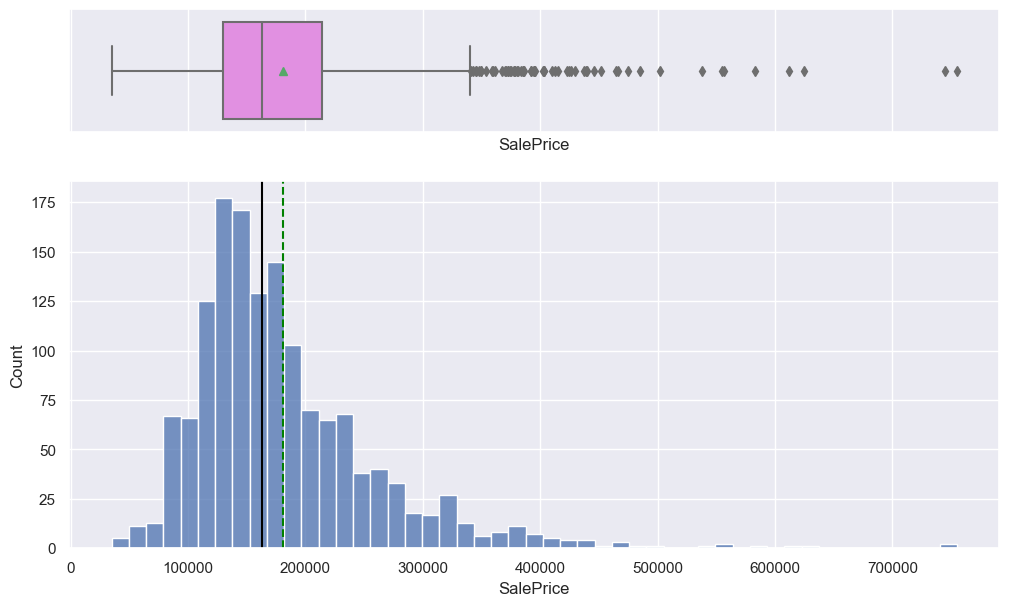

In [183]:
# inspecting dependent saleprice distribution
histogram_boxplot(Y,'SalePrice')

**Observations**

* Saleprice data is skewed
* Perform a log transform to reduce skewness and check if it helps normalize the distribution

C:\Users\ajmer\AppData\Local\Temp\ipykernel_17704\1771731593.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['Log_SalePrice'] = np.log(Y['SalePrice'])
C:\Users\ajmer\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


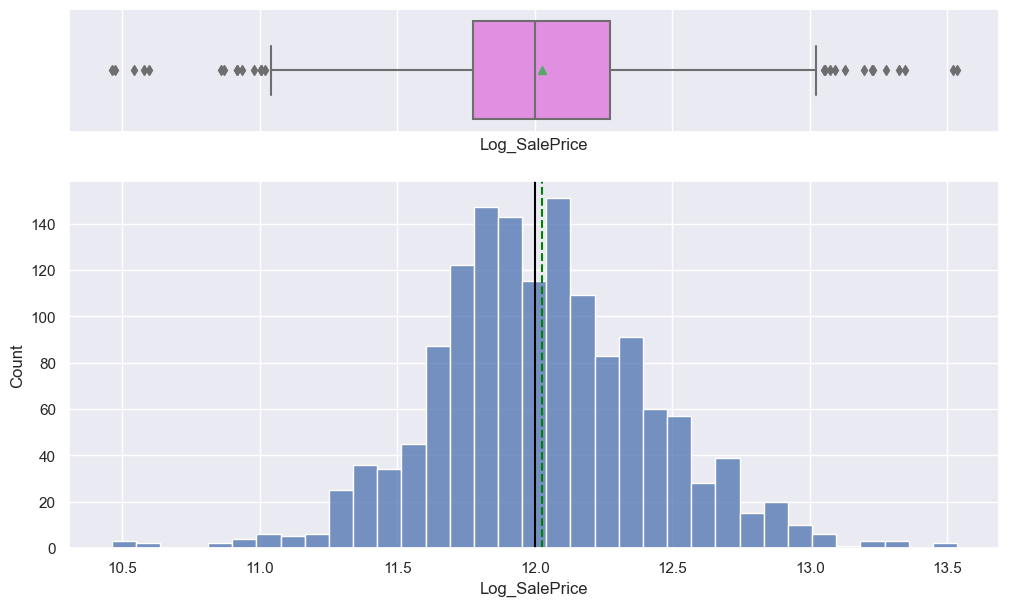

In [184]:
Y['Log_SalePrice'] = np.log(Y['SalePrice'])
histogram_boxplot(Y,'Log_SalePrice')

* Log transform has significantly helped in reducing the skewness and normalizing the sale price

**Outlier Detection Using Boxplots**

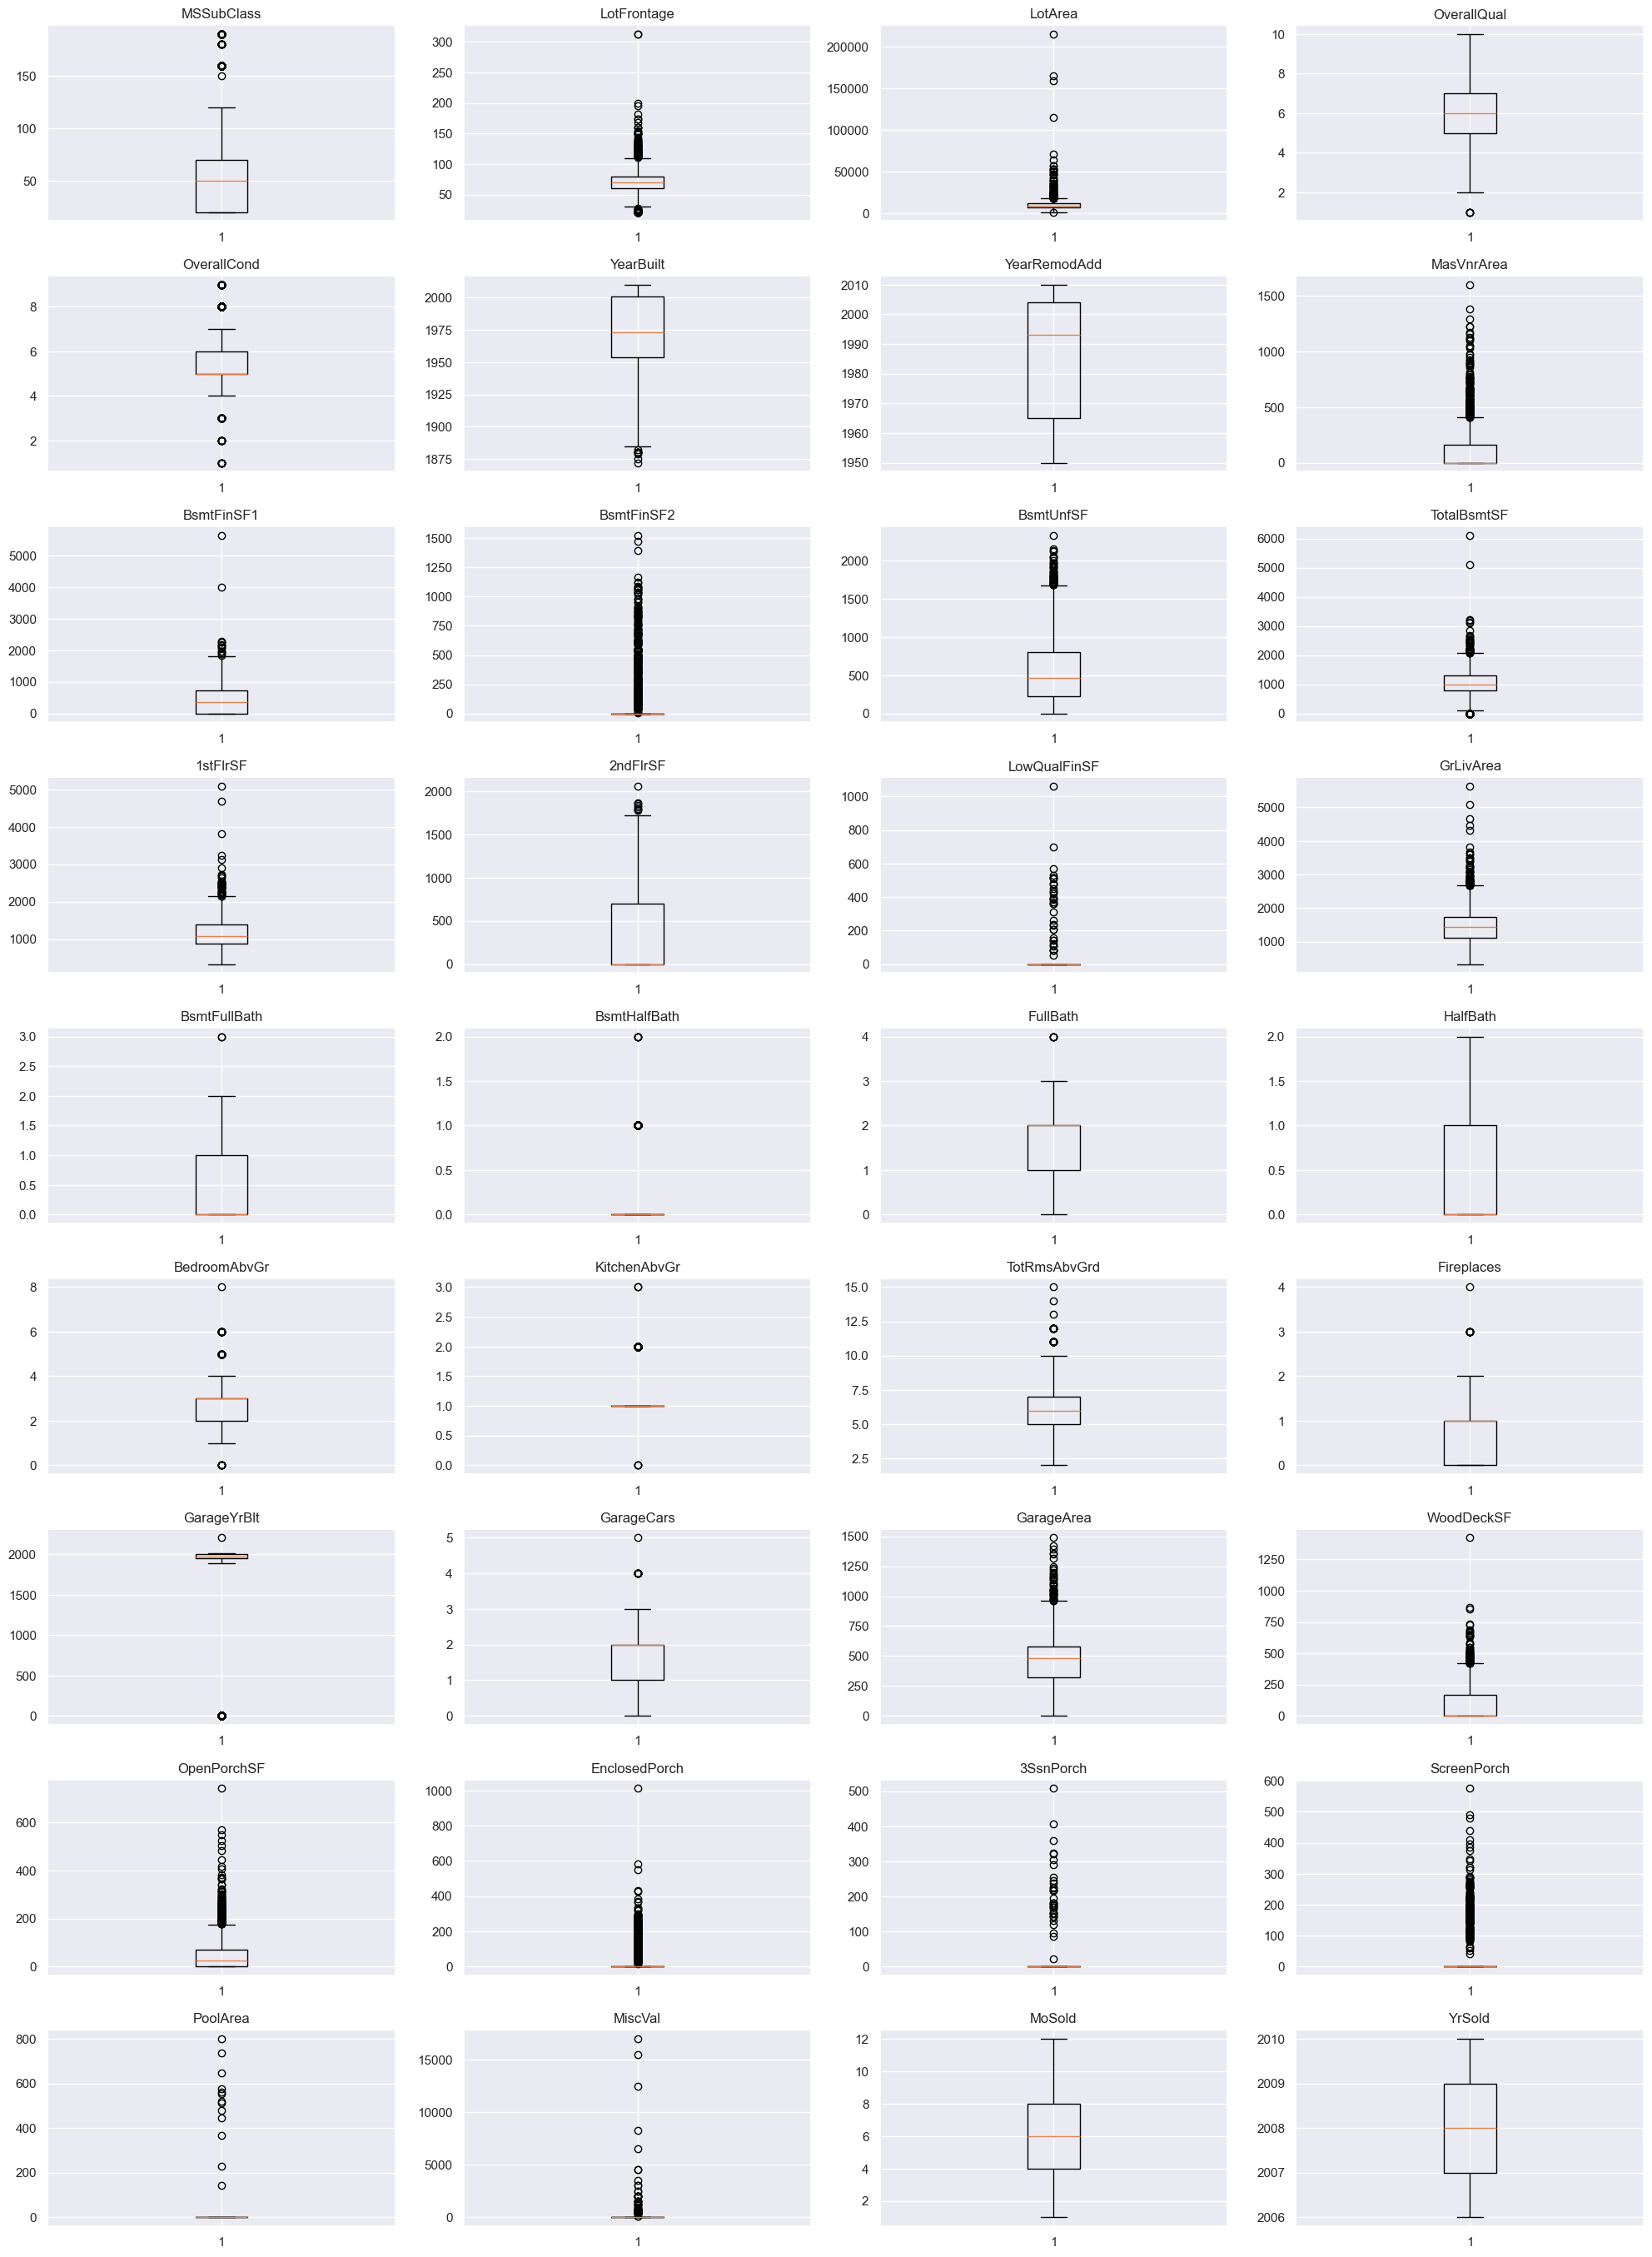

In [185]:
#outlier inspection

numerical_col = traincombined.loc[:,traincombined.columns != 'Training'].select_dtypes(exclude='object').columns.tolist()
plt.figure(figsize=(20,30))

for i,variable in enumerate(numerical_col):
    plt.subplot(10,4,i+1) #5
    plt.boxplot(traincombined[variable],whis=1.5)
    plt.tight_layout()
    plt.title(variable)
plt.show()    

**Observations**

* `LotFrontage`, `LotArea`, `MasVnrArea`, `BsmtFinSF2`, `GarageArea`, and `ScreenPorch` have prominent upper outliers
* `YearBuilt` appears to have some lower outliers
* `OverallCond`, `BedroomAbvGr`, and `GarageYrBlt` have both upper and lower outliers

In [186]:
# functions to treat outliers by flooring and capping
 

def treat_outliers(df, col):

    """

    Treats outliers in a variable

 

    df: dataframe

    col: dataframe column

    """

    Q1 = df[col].quantile(0.25)  # 25th quantile

    Q3 = df[col].quantile(0.75)  # 75th quantile

    IQR = Q3 - Q1

    Lower_Whisker = Q1 - 1.5 * IQR

    Upper_Whisker = Q3 + 1.5 * IQR

 

    # all the values smaller than Lower_Whisker will be assigned the value of Lower_Whisker

    # all the values greater than Upper_Whisker will be assigned the value of Upper_Whisker

    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker)

 

    return df

 

def treat_outliers_all(df, col_list):
    """
    Treat outliers in a list of variables
 

    df: dataframe

    col_list: list of dataframe columns
    """

    for c in col_list:

        df = treat_outliers(df, c)

 

    return df

The above function will identify outliers that we define as being above or below the 75th and 25th quartiles and will impute them with the values of the upper and lower boxplot whiskers

In [187]:
train_final = treat_outliers_all(traincombined,numerical_col)
#train_final

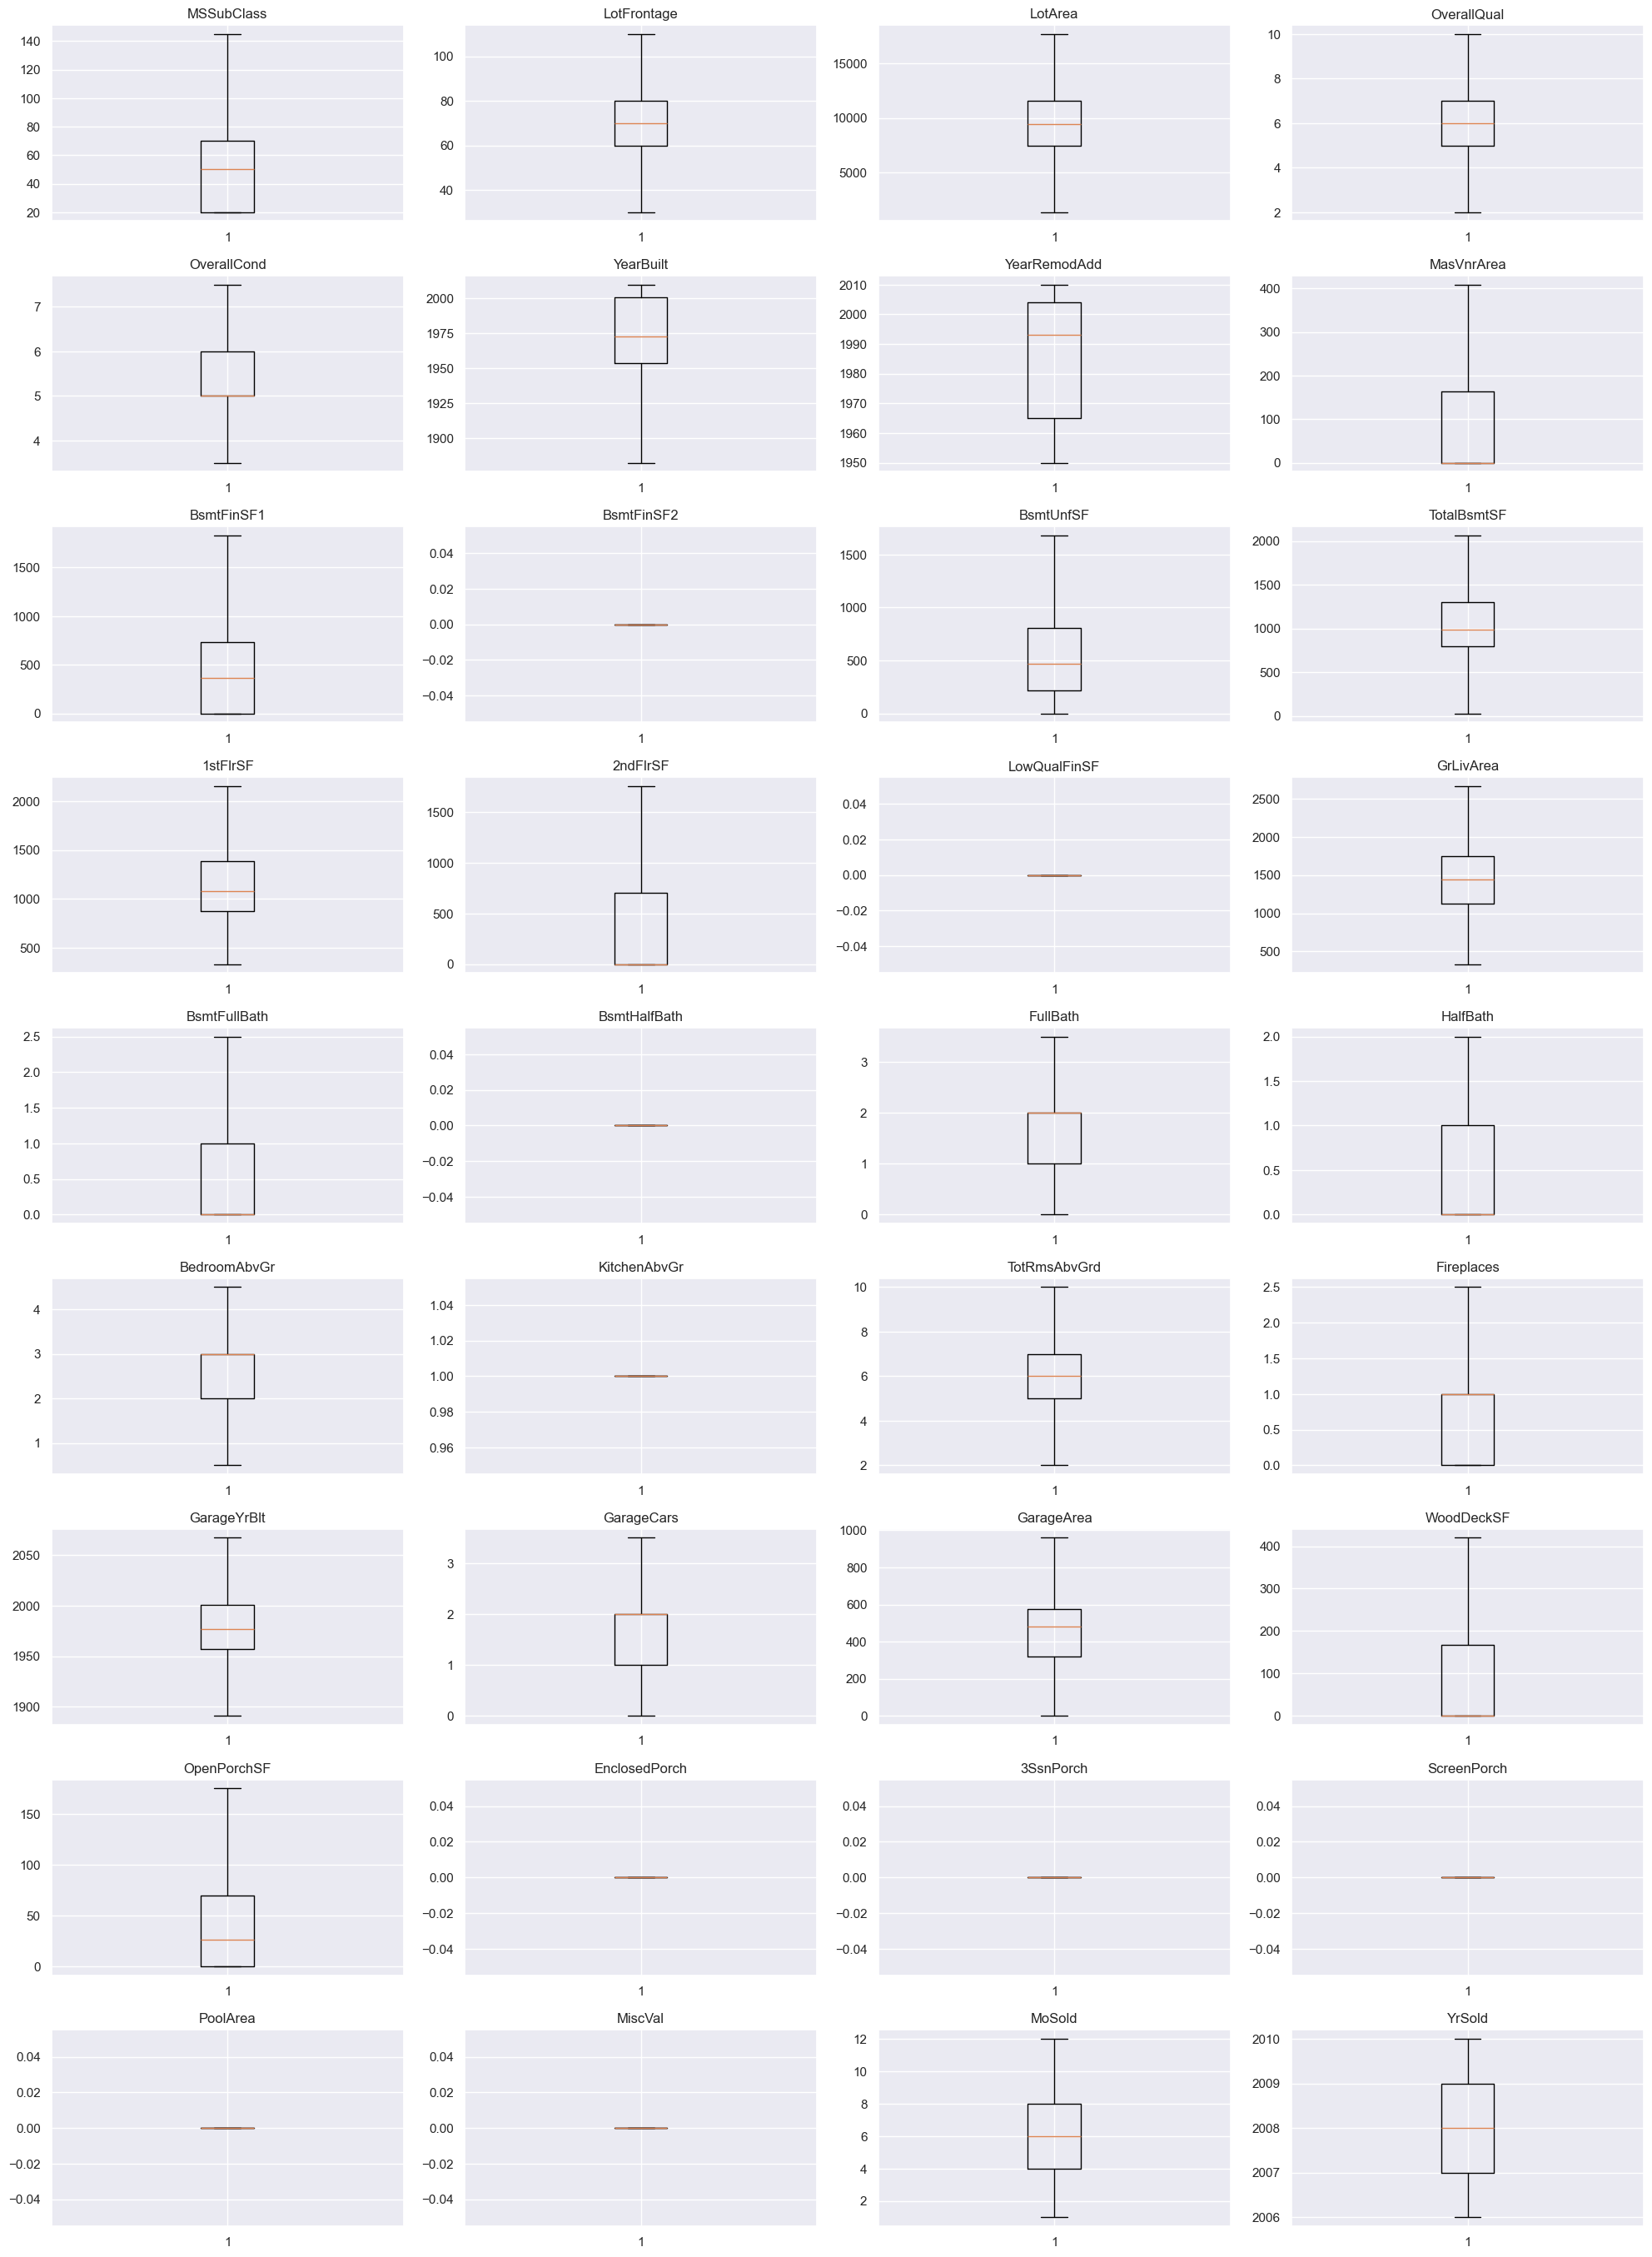

In [188]:
plt.figure(figsize=(20,30))

for i,variable in enumerate(numerical_col):
    plt.subplot(10,4,i+1) 
    plt.boxplot(train_final[variable],whis=1.5)
    plt.tight_layout()
    plt.title(variable)
plt.show()   

Looking at the boxplots again we can see that the outliers have been treated

### Summary of EDA + Preprocessing

**Data Description**

* The target dependent variable `SalePrice` is of *float* type
* All other fields are of *object*, *float*, and *int* types
* The train and test data sets are combined to speed up the process of data cleaning and outlier treatments
* `ID` field is dropped as it serves no purposes in model training, values are saved to seperate variables
* There missing values in the data. Fields with missing data have been filled using most frequent imputation, median imputation, and context provided by the data dictionary


**Observations from EDA**

* The dependent variable `SalePrice` showed signs of right skewness. Log transform was applied to normalize the values and reduce the skew
* Majority of the features showed signs of outliers. A custom function was applied to treat all outliers falling above or below the 75th and 25th quartiles

## Model Building

1. We need to predict the housing saleprices. Since `SalePrice` is a skewed variable we will build the model using both the actual and transformed log version
2. Need to explore Lasso and Ridge regression techniques
3. We will build an initial model using simple linear regression and compare the performance against Lasso and Ridge to determine the best option 

### Define independent and dependent variables

In [189]:
# defining the dependent and independent variables for training data
X = train_final.loc[train_final.Training == 1]
y = Y["SalePrice"]

# Test Data
X_test = train_final.loc[train_final.Training == 0]

#dropping columns
X = X.drop('Training',axis=1)
X_test = X_test.drop('Training',axis=1)


### Encoding Categorical Fields

In [190]:
X = pd.get_dummies(X,columns=X.select_dtypes(include=["object", "category"]).columns.tolist(),drop_first=True)
X_test = pd.get_dummies(X_test,columns=X_test.select_dtypes(include=["object", "category"]).columns.tolist(),drop_first=True)

X = X[list(X_test)] # ensuring training data contains the same set of features in the test data file. Needed to determine predictions later
X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_No Alley Access,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_No Basement,BsmtQual_TA,BsmtCond_Gd,BsmtCond_No Basement,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_No Basement,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_No Basement,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_No Basement,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasW,Heating_Grav,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_No Fireplace,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No Garage,GarageFinish_No Garage,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Gd,GarageQual_No Garage,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_No Garage,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolQC_Gd,PoolQC_No Pool,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_No Fence,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5.0,2003.0,2003,196.0,706.0,0.0,150.0,856.0,856.0,854,0,1710.0,1.0,0.0,2.0,1,3.0,1,8,0.0,2003.0,2.0,548.0,0,61,0,0,0,0,0,2,20

**Model 1: Linear Regression Using `SalePrice`**

In [191]:
# splitting the data in 70:30 ratio for train to test data

x_train1, x_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=69)

In [192]:
print("Number of rows in train data =", x_train1.shape[0])
print("Number of rows in test data =", x_test1.shape[0])

Number of rows in train data = 1022
Number of rows in test data = 438


In [193]:
# fitting a linear model
lin_reg_model1 = LinearRegression()
lin_reg_model1.fit(x_train1, y_train1)

LinearRegression()

**Check Coefficients and Intercept**

In [194]:

coef_df1 = pd.DataFrame(
    np.append(lin_reg_model1.coef_, lin_reg_model1.intercept_),
    index=x_train1.columns.tolist() + ["Intercept"],
    columns=["Coefficients"],
)
coef_df1

,Coefficients
MSSubClass,-84.060819
LotFrontage,135.612190
LotArea,1.647905
OverallQual,7631.381093
OverallCond,5837.685343
...,...
SaleCondition_Alloca,-3395.884853
SaleCondition_Family,-1417.025657
SaleCondition_Normal,4838.849714
SaleCondition_Partial,-18316.299739


### Model performance check

* Using Metric functions defined in Sklearn for RMSE, MAPE, and $R^2$
* Creating a function that will print all metrics in a single execution which will be called upon for all models

In [195]:
# function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

In [196]:
# Checking model performance on train set
print("Training Performance:")
lin_reg_model1_perf_train = model_performance_regression(
    lin_reg_model1, x_train1, y_train1
)
lin_reg_model1_perf_train

Training Performance:


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,20137.503808,13836.563769,0.938141,0.919028,8.239738


In [197]:
# Checking model performance on test set
print("Test Performance:")
lin_reg_model1_perf_test = model_performance_regression(lin_reg_model1, x_test1, y_test1)
lin_reg_model1_perf_test

Test Performance:


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,43813.449039,19777.369659,0.664541,0.252064,12.048905


**Model 2: Linear Regression Using `Logged SalePrice`**

In [198]:
# Defining dependent variable
y = Y["Log_SalePrice"]

# splitting the data in 70:30 ratio for train to test data

x_train2, x_test2, y_train2, y_test2 = train_test_split(
    X, y, test_size=0.3, random_state=69
)

print("Number of rows in train data =", x_train2.shape[0])
print("Number of rows in test data =", x_test2.shape[0])

Number of rows in train data = 1022
Number of rows in test data = 438


In [199]:
# fitting a linear model
lin_reg_model2 = LinearRegression()
lin_reg_model2.fit(x_train2, y_train2)

LinearRegression()

**Check Coefficients and Intercept**

In [200]:

coef_df2 = pd.DataFrame(
    np.append(lin_reg_model2.coef_, lin_reg_model2.intercept_),
    index=x_train2.columns.tolist() + ["Intercept"],
    columns=["Coefficients"],
)
coef_df2

,Coefficients
MSSubClass,-0.000106
LotFrontage,0.000571
LotArea,0.000009
OverallQual,0.045581
OverallCond,0.040337
...,...
SaleCondition_Alloca,0.006737
SaleCondition_Family,0.036779
SaleCondition_Normal,0.049006
SaleCondition_Partial,-0.030364


In [201]:
# Checking model performance on train set
print("Training Performance:")
lin_reg_model2_perf_train = model_performance_regression(
    lin_reg_model2, x_train2, y_train2
)
lin_reg_model2_perf_train

Training Performance:


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.089221,0.065374,0.951413,0.936401,0.547746


In [202]:
# Checking model performance on test set
print("Test Performance:")
lin_reg_model2_perf_test = model_performance_regression(lin_reg_model2, x_test2, y_test2)
lin_reg_model2_perf_test

Test Performance:


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.174675,0.092028,0.795078,0.543107,0.769398


In [203]:
# training and Test performance comparison

models_train_comp_df = pd.concat(
    [
        lin_reg_model1_perf_train.T,
        lin_reg_model2_perf_train.T,
        lin_reg_model1_perf_test.T,
        lin_reg_model2_perf_test.T
    ],
    axis=1,
)

models_train_comp_df.columns = [
    "Linear Regression (SalePrice) Training",
    "Linear Regression (saleprice_log) Training",
    "Linear Regression (SalePrice) Testing",
    "Linear Regression (saleprice_log) Testing"
]

print("Training and Test performance comparison:")
models_train_comp_df

Training and Test performance comparison:


,Linear Regression (SalePrice) Training,Linear Regression (saleprice_log) Training,Linear Regression (SalePrice) Testing,Linear Regression (saleprice_log) Testing
RMSE,20137.503808,0.089221,43813.449039,0.174675
MAE,13836.563769,0.065374,19777.369659,0.092028
R-squared,0.938141,0.951413,0.664541,0.795078
Adj. R-squared,0.919028,0.936401,0.252064,0.543107
MAPE,8.239738,0.547746,12.048905,0.769398


**Observations**

- $R^2$ results for model1 and model2 are both high on the training sets. However on the test sets the value drops substantially indicating signs of overfitting

-  $R^2$ result for model2 using the transformed saleprice does have an improved $R^2$ = 0.61 and a lower MAPE score of 0.83 % vs 12.65 % from model1

-  We can conclude that the log transformation definitely helped in improving performance however the overall model is still performing poorly on the test data and is overfitting

### Lasso and Ridge Regression

**Model 3: Lasso Regression Using `Logged SalePrice`**

In [204]:
# Redefining the dependent and independent variables

# splitting the data in 70:30 ratio for train to test data
y = Y['Log_SalePrice']
x_train3, x_test3, y_train3, y_test3 = train_test_split(
    X, y, test_size=0.3, random_state=69
)

print("Number of rows in train data =", x_train3.shape[0])
print("Number of rows in test data =", x_test3.shape[0])


Number of rows in train data = 1022
Number of rows in test data = 438


**Cross Validation to Determine Optimal Alpha**

In [205]:
# Create and fit the Lasso regression model with cross-validation


lasso_cv_model = LassoCV(cv=10, random_state=0)
lasso_cv_model.fit(x_train3, y_train3)

# Get the best alpha
best_alpha = lasso_cv_model.alpha_
print(f'Best alpha: {best_alpha}')

Best alpha: 0.6565461097011125


In [206]:
# fitting a lasso model
lin_reg_model3 = Lasso(alpha=best_alpha)
lin_reg_model3.fit(x_train3, y_train3)

Lasso(alpha=0.6565461097011125)

**Check Coefficients and Intercepts**

In [207]:


coef_df3 = pd.DataFrame(
    np.append(lin_reg_model3.coef_, lin_reg_model3.intercept_),
    index=x_train3.columns.tolist() + ["Intercept"],
    columns=["Coefficients"],
)
coef_df3

,Coefficients
MSSubClass,-0.000000
LotFrontage,0.000000
LotArea,0.000011
OverallQual,0.000000
OverallCond,0.000000
...,...
SaleCondition_Alloca,-0.000000
SaleCondition_Family,-0.000000
SaleCondition_Normal,0.000000
SaleCondition_Partial,0.000000


In [208]:
# Checking model performance on train set
print("Training Performance:")
lin_reg_model3_perf_train = model_performance_regression(
    lin_reg_model3, x_train3, y_train3
)
lin_reg_model3_perf_train

Training Performance:


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.16471,0.114061,0.834415,0.783253,0.95603


In [209]:
# Checking model performance on test set
print("Test Performance:")
lin_reg_model3_perf_test = model_performance_regression(lin_reg_model3, x_test3, y_test3)
lin_reg_model3_perf_test

Test Performance:


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.177456,0.116214,0.788502,0.528446,0.970936


**Model 4: Ridge Regression Using `Logged SalePrice`**

In [210]:
# redefining the dependent and independent variables

# splitting the data in 70:30 ratio for train to test data
y = Y['Log_SalePrice']
x_train4, x_test4, y_train4, y_test4 = train_test_split(
    X, y, test_size=0.3, random_state=69
)

print("Number of rows in train data =", x_train4.shape[0])
print("Number of rows in test data =", x_test4.shape[0])


Number of rows in train data = 1022
Number of rows in test data = 438


**Cross Validation to Determine Optimal Alpha**

In [211]:
# Create and fit the Ridge regression model with cross-validation

ridge_cv_model = RidgeCV(cv=10)
ridge_cv_model.fit(x_train4, y_train4)

# Get the best alpha
best_alpha = ridge_cv_model.alpha_
print(f'Best alpha: {best_alpha}')

Best alpha: 10.0


In [212]:
# fitting a ridge model
lin_reg_model4 = Ridge(alpha=best_alpha)
lin_reg_model4.fit(x_train4, y_train4)

Ridge(alpha=10.0)

**Check Coefficients and Intercept**

In [213]:

coef_df4 = pd.DataFrame(
    np.append(lin_reg_model4.coef_, lin_reg_model4.intercept_),
    index=x_train4.columns.tolist() + ["Intercept"],
    columns=["Coefficients"],
)
coef_df4

,Coefficients
MSSubClass,-0.000311
LotFrontage,0.000378
LotArea,0.000009
OverallQual,0.057187
OverallCond,0.047860
...,...
SaleCondition_Alloca,-0.020900
SaleCondition_Family,0.017132
SaleCondition_Normal,0.047459
SaleCondition_Partial,0.019379


In [214]:
# Checking model performance on train set
print("Training Performance:")
lin_reg_model4_perf_train = model_performance_regression(
    lin_reg_model4, x_train4, y_train4
)
lin_reg_model4_perf_train

Training Performance:


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.103695,0.072742,0.93437,0.914092,0.609887


In [215]:
# Checking model performance on test set
print("Test Performance:")
lin_reg_model4_perf_test = model_performance_regression(lin_reg_model4, x_test4, y_test4)
lin_reg_model4_perf_test

Test Performance:


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.132622,0.081064,0.881872,0.736622,0.678264


In [222]:
# training and Test performance comparison

models_train_comp_df_LR = pd.concat(
    [
        lin_reg_model3_perf_train.T,
        lin_reg_model4_perf_train.T,
        lin_reg_model3_perf_test.T,
        lin_reg_model4_perf_test.T
    ],
    axis=1,
)

models_train_comp_df_LR.columns = [
    "Lasso Regression Training",
    "Ridge Regression Training",
    "Lasso Regression Testing",
    "Ridge Regression Testing"
]

print("Training and Test performance comparison:")
models_train_comp_df_LR

Training and Test performance comparison:


,Lasso Regression Training,Ridge Regression Training,Lasso Regression Testing,Ridge Regression Testing
RMSE,0.164710,0.103695,0.177456,0.132622
MAE,0.114061,0.072742,0.116214,0.081064
R-squared,0.834415,0.934370,0.788502,0.881872
Adj. R-squared,0.783253,0.914092,0.528446,0.736622
MAPE,0.956030,0.609887,0.970936,0.678264


**Observations**

- Lasso and Ridge regression return the highest $R^2$ on the testing data and the values are comparable to the training set which proves there is no overfitting

- Ridge Regression in particular yielded the highest $R^2$ = 0.88 on the test set and an MAPE of 0.678 % which is lowest out of all 4 models



Given these results it is evidient that Ridge Regression has the best performance and we will proceed with this model to determine the house price predictions

## Predictions

In [218]:
predictions_ridge = lin_reg_model4.predict(X_test)

#undoing log transformation in order to get real valued house prices 
predictions_ridge = np.exp(predictions_ridge)
predictions_ridge

array([108816.39826255, 163155.97699173, 184812.47893207, ...,
       180231.86520807, 112861.44811318, 223035.93160831])

In [219]:
ridge = pd.DataFrame({'Id':test_id.to_list(),'SalePrice':predictions_ridge.tolist()})
ridge.to_csv('ridge_08_14.csv',index = False)

In [223]:
ridge.head()

,Id,SalePrice
0,1461,108816.398263
1,1462,163155.976992
2,1463,184812.478932
3,1464,197854.131106
4,1465,179118.431243
